# ASTR 596: FDS Homework 4 - Monte Carlo Basics

We've already looked at the simple, most general Monte Carlo algorithm, and you used it on your last homework set.

## Simple Monte Carlo

A posterior is already naturally factored into a likelihood function and a prior PDF.

## $$p(\theta|x) \propto p(x|\theta)\,p(\theta)$$

Applying this in the MC integration context leads to the Simple Monte Carlo algorithm:

```
while we want more samples
    draw theta from p(theta)
    compute weight = p(x|theta)
    store theta and weight
```

Obtaining marginal distribution(s) for $\theta$ then reduces to constructing weighted histograms of the samples.

SMC is indeed simple (as long as the prior is simple to draw from), but if the priors are not very informative then it still wastes many likelihood evaluations where the posterior is small. 

However, refinements of this approach lead to some more advanced algorithms. Once class of refinements is in how the samples are drawn:

### Rejection sampling
For this method, we need to define an *envelope function* which everywhere exceeds the target PDF, $p(x)$, and can be sampled. Let this be $Ag(x)$ where $A$ is a scaling factor and $g(x)$ is a PDF we know.

Then the algorithm is
```
while we want more samples
    draw a random value for x from some distribution g in the variable x
    draw u from Uniform(0,1)
    if u <= p(x)/(A*g(x)), keep the sample x
    otherwise, reject x
```

# Problem 1: Rejection Sampling

Implement a rejection sampler corresponding to the example figure above that illustrates the method. For this example,

* $p(x)$ is the $\chi^2$ distribution with 3 degrees of freedom

* $A=\pi$

* $g(x)$ is a normal distribution with mean 0 and standard deviation 5

Verify that your samples do indeed approximate the target PDF.

In [1]:
# YOUR CODE HERE
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import hist as ahist
import seaborn as sns

In [2]:
A = np.pi

In [3]:
u = np.random.uniform(low=0.0, high=1.0, size=10000)

In [4]:
x = st.norm.rvs(loc=0, scale=5.0, size=10000, random_state=None)

rejct_crit = st.chi2.pdf(x,3)/(A*st.norm.pdf(x,loc=0, scale=5.0))

x_est = x[u < rejct_crit]

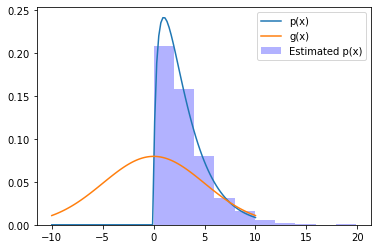

In [7]:
xx = np.linspace(-10,10,100)
plt.plot(xx, st.chi2.pdf(xx,3),label='p(x)')
plt.plot(xx, st.norm.pdf(xx,loc=0, scale=5.0),label='g(x)')
plt.hist(x_est,color='b',alpha=0.3,density=True,label='Estimated p(x)')
plt.legend()

# Problem 2: Metropolis


You guessed it... Implement the Metroplis Hastings algorithm in python.
Your implementation should accept an arbitary function as an argument (just as you've been passing to `scipy.optimize`)

Test it by sampling both the `circle` and `pgauss` function below 10,000 times and plotting your samples as you did in class (don't plot up your rejected). You can implement a prior function that imposes bounds. 

Look at your first 100 samples and then samples 500 to 600 for the `pgauss` case and comment on the difference. Think about this on Problem 3!

In [43]:
# YOUR CODE HERE

def circle(x, y):
    return (x-1)**2 + (y-2)**2 - 3**2

mus = np.array([5, 5])
sigmas = np.array([[1, .9], [.9, 1]])

def pgauss(x, y):
    return st.multivariate_normal.pdf([x, y], mean=mus, cov=sigmas)

In [44]:
def metropolis(func,n_iter=1000):
    x_accept = []
    y_accept = []
    x, y = 0,0
    
    for i in range(n_iter):
        new_x = x + st.norm.rvs(loc=0, scale=1, size=1, random_state=None)[0]
        new_y = y + st.norm.rvs(loc=0, scale=1, size=1, random_state=None)[0]
    
        if np.random.uniform(low=0.0, high=1.0, size=1)[0] < np.min(np.array([1, func(new_x, new_y) / func(x, y)])):
            x = new_x
            y = new_y
            x_accept.append(x)
            y_accept.append(y)
        
    return x_accept, y_accept       

In [45]:
x_circ,y_circ = metropolis(circle, n_iter=10000)

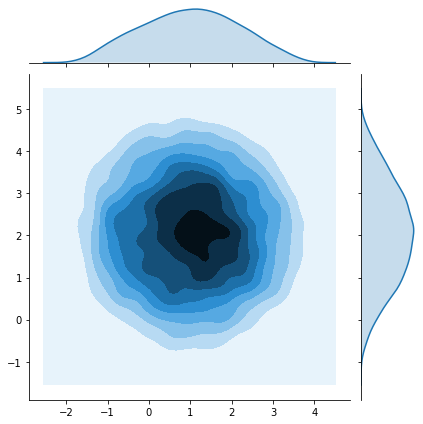

In [46]:
ax = sns.jointplot(x=x_circ,y=y_circ,kind='kde')

In [47]:
x_gauss,y_gauss = metropolis(pgauss, n_iter=10000)

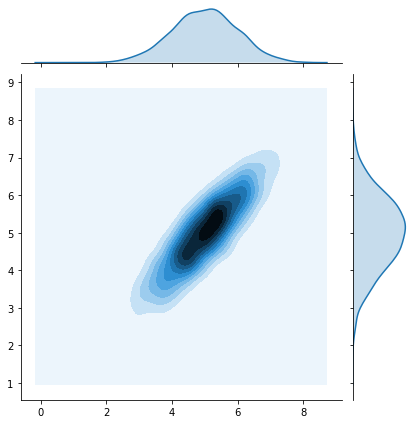

In [48]:
ax = sns.jointplot(x=x_gauss,y=y_gauss,kind='kde')

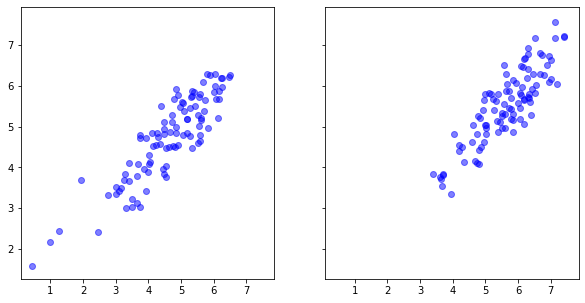

In [49]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5),sharey=True,sharex=True)
#ax = fig.add_subplot(1,2,1)
ax1.scatter(x_gauss[0:100],y_gauss[0:100], color='blue',alpha=0.5)
ax2.scatter(x_gauss[500:600],y_gauss[500:600], color='blue',alpha=0.5)

## Problem 3: Using your sampler for a real problem where a grid would have been really painful.


We'll be analyzing data from the Optical Gravitational Lensing Experiment (OGLE), which monitors stars in our galaxy in the hopes of detecting gravitational microlensing events that occur when a compact mass (e.g. a fainter star) passes in front of the monitored star.

You can read more about microlensing here if you like:
https://en.wikipedia.org/wiki/Gravitational_microlensing

Data are available through the [OGLE Early Warning System](http://ogle.astrouw.edu.pl/ogle4/ews/ews.html). Scroll down a bit to the list of recent events and choose one to analyze. (Not the one shown below. Be original.) The event summary page will include a plot like this.

<table>
    <tr>
        <td><img src="http://ogle.astrouw.edu.pl/ogle4/ews/2019/data/2019/blg-0001/lcurve.gif" width=75%></td>
    </tr>
</table>

As long as a vaguely reasonable looking magenta line is shown, this should be a good data set to fit. Download the `phot.dat` for your chosen event (linked at the bottom of the webpage).

As described on the OGLE page, the columns of this text file are

> Hel.JD, I magnitude, magnitude error, seeing estimation (in pixels - 0.26"/pixel) and sky level

* Heliocentric Julian Date. This is time, measured in days, since a fixed reference. The "heliocentric" part means that it has been corrected to the reference frame of the Sun, i.e. the few minutes of light travel time more or less that would affect photon arrivals at different parts of the Earth's year have been subtracted off.

* Measurements of magnitude in the $I$ band (a near infrared band). Recall that astronomical magnitude, relative to a given reference source, is given by the relationship $m = m_\mathrm{ref} - 2.5\,\log_{10}\left(\frac{F}{F_\mathrm{ref}}\right)$, where $F$ is flux.

* Measurement uncertainty on the $I$ magnitude, defined in some unspecified way (digging through papers might elucidate this).

* The "seeing" and "sky level" quantities refer to the observing conditions, which we will not work with directly. These will have been accounted for (somehow) in deriving the best-fitting magnitude and its uncertainty.


As Bayesian's we have 4 questions to answer
1. What's the model?
2. What's the Likelihood?
3. What's the Prior?
4. How do you sample?


I'll tell you 1. and you've already written down the answer to 4.


## $$F(t) = F_0 \frac{u(t)^2 + 2}{u(t)\sqrt{u(t)^2+4}}$$

where

## $$u(t) = \sqrt{p^2 + \left( \frac{t-t_\mathrm{max}}{t_\mathrm{E}} \right)^2}$$

You'll of course also need the transformation between flux and magnitude, above. For convenience, let's parameterize the normalization of the model lightcurve in magnitudes rather than flux, i.e. $I_0$ rather than $F_0$; that way, all of the "ref" quantities in the magnitude definition are absorbed into this new parameter and we won't have to worry about them explicitly. With that substitution, the model parameters are $I_0$, $p$, $t_\mathrm{max}$ and $t_\mathrm{E}$. 

* $t_\mathrm{E}$ is the Einstein crossing time - you can also get some initial guess for this from the data itself

* $t_\mathrm{max}$ is the time of maximum - which you should be able to read off from the plot

* $p$ is the peak magnification - You can also get a guess of this and $I_0$ from the data. Look at the functional form of the model at times far from $t_\mathrm{max}$.


Lacking any better information, we'll assume that the sampling distributions for the magnitude measurements are Gaussian and independent, with means given by the "magnitude" column and standard deviations given by the "magnitude error" column, and that the time stamps are exact.


Do an MCMC fit of this microlensing model to your lightcurve data
This fit should be doable, if potentially annoying, with your Metropolis-Hastings implementation.

Your solution should include the following:

1. expressions (in readable code, at a minimum) of the prior distributions and likelihood encoded (i.e. Q2 for a Bayesian)
2. some justification of the choice of priors (Q3. for a Bayesian can be brief)
3. plots showing traces of each parameter, and an identified burn-in period
4. some evaluation of how well the fit has converged (see below)
5. 1D histograms of the parameter samples and 2D contour plots of parameter pairs (you can just use the `corner` package for this, which makes it trivial - you can see how in homework from week 1)
6. "best fit" values and 68.3% confidence intervals from the 1D marginalized posteriors of each parameter. 
7. a plot of the best-fitting model lightcurve over the data, and some qualitative comments about how good a fit it appears (hint: depending on your data set, you may need to zoom in quite a lot to get a good look)

In [3]:
import pandas as pd

In [4]:
dat = pd.read_csv("phot.dat",header=None,sep='\s+')
JD = dat[0] - 2.458e6
mag = dat[1]
mag_err = dat[2]

In [5]:
len(JD)

2773

In [6]:
# I0, p, tmax, tE i.e average, amplitude, t at which maximum occurs, tE is width
#initial_guess = np.array([13.2 , -0.7, 600, 120])
initial_guess = np.array([11 , -0.4, 500, 60])

In [7]:
def model_func(t,I0,p,tmax,tE):
    #I0,p,tmax,tE = theta
    u = np.sqrt(p**2 + ((t-tmax)/tE)**2)
    #I = I0 * ((u**2 + 2)/(u*np.sqrt(u**2 + 4))) 
    I = I0 - 2.5*np.log10(((u**2 + 2)/(u*np.sqrt(u**2 + 4)))) 
    return I  

In [9]:
def lnprior(I0,p,tmax,tE):
    #I0,p,tmax,tE = theta
    if 10 < I0 < 18 and -1.5 < p < 0.3 and 400 < tmax < 700 and 30 < tE < 80:
        return 0.
    else:
        return -np.inf
    
def lnlike(I0,p,tmax,tE, func, x, true_I, true_Ierr):
    model_I = func(x, I0,p,tmax,tE)
    LnLike = np.sum((true_I - model_I)**2/(2*(true_Ierr**2)))
    return LnLike



In [10]:
def mcmc(func,initial,lnlike,lnprior,xdata, ydata,ydata_err,n_iter=1000):
    I0_accept = []
    p_accept = []
    tmax_accept = []
    tE_accept = []
    lnlike_value = []
    
    I0 = initial[0]
    p = initial[1]
    tmax = initial[2]
    tE = initial[3]
        
    for i in range(n_iter):
        new_I0 = I0 + st.norm.rvs(loc=0, scale=1, size=1, random_state=None)[0]
        new_p = p + st.norm.rvs(loc=0, scale=1, size=2, random_state=None)[0]
        new_tmax = tmax + st.norm.rvs(loc=0, scale=2, size=1, random_state=None)[0]
        new_tE = tE + st.norm.rvs(loc=0, scale=2, size=1, random_state=None)[0]
        
        if np.random.uniform(low=0.0, high=1.0, size=1)[0] <= np.min(np.array([1, ((lnlike(I0,p,tmax,tE,func,xdata,ydata,ydata_err) / lnlike(new_I0,new_p,new_tmax,new_tE,func,xdata,ydata,ydata_err))+
                                                                             lnprior(new_I0,new_p,new_tmax,new_tE))])):
            I0 = new_I0
            p = new_p
            tmax = new_tmax
            tE = new_tE
            
            I0_accept.append(I0)
            p_accept.append(p)
            tmax_accept.append(tmax)
            tE_accept.append(tE)
            lnlike_value.append(lnlike(I0,p,tmax,tE,func,xdata,ydata,ydata_err))
        
    return I0_accept, p_accept, tmax_accept,tE_accept,lnlike_value



In [12]:
I0_model, p_model, tmax_model, tE_model,lnlike_val = mcmc(model_func,initial_guess,lnlike,lnprior,JD,mag,mag_err,n_iter=100000)



Text(0.5, 1.0, 'I0_Chains')

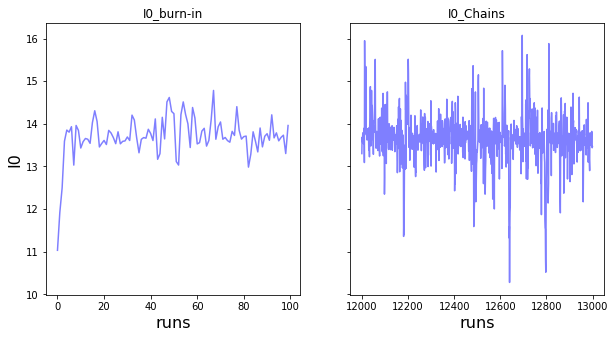

In [29]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5),sharey=True)
#ax = fig.add_subplot(1,2,1)
#ax1.scatter(np.arange(0,100,1),I0_model[0:100], color='blue',s=0.8)
ax1.plot(np.arange(0,100,1),I0_model[0:100], color='blue',alpha=0.5)
ax1.set_xlabel("runs",fontsize=16)
ax1.set_ylabel("I0",fontsize=16)
ax2.plot(np.arange(12000,13000,1),I0_model[12000:13000], color='blue',alpha=0.5)
#ax2.scatter(np.arange(5000,6000,1),I0_model[5000:6000], color='blue',s=0.8)
ax2.set_xlabel("runs",fontsize=16)
ax1.set_title("I0_burn-in")
ax2.set_title("I0_Chains")

Text(0.5, 1.0, 'p_Chains')

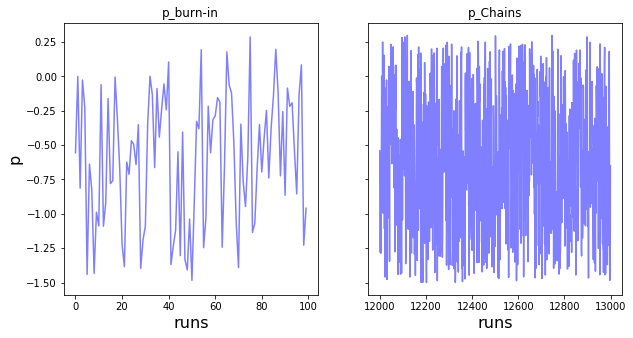

In [30]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5),sharey=True)
#ax = fig.add_subplot(1,2,1)
ax1.plot(np.arange(0,100,1),p_model[0:100], color='blue',alpha=0.5)
ax1.set_xlabel("runs",fontsize=16)
ax1.set_ylabel("p",fontsize=16)
ax2.plot(np.arange(12000,13000,1),p_model[12000:13000], color='blue',alpha=0.5)
ax2.set_xlabel("runs",fontsize=16)
ax1.set_title("p_burn-in")
ax2.set_title("p_Chains")

Text(0.5, 1.0, 'tmax_Chains')

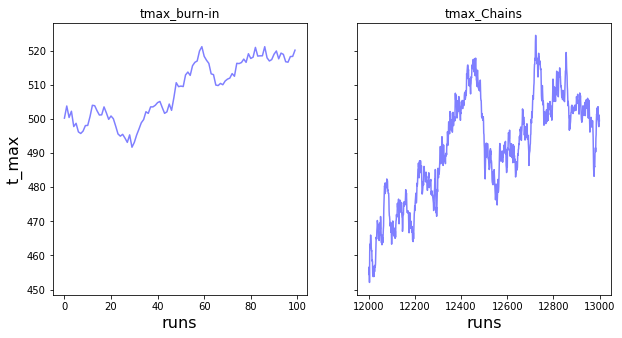

In [31]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5),sharey=True)
#ax = fig.add_subplot(1,2,1)
ax1.plot(np.arange(0,100,1),tmax_model[0:100], color='blue',alpha=0.5)
ax1.set_xlabel("runs",fontsize=16)
ax1.set_ylabel("t_max",fontsize=16)
ax2.plot(np.arange(12000,13000,1),tmax_model[12000:13000], color='blue',alpha=0.5)
ax2.set_xlabel("runs",fontsize=16)
ax1.set_title("tmax_burn-in")
ax2.set_title("tmax_Chains")

Text(0.5, 1.0, 'tE_Chains')

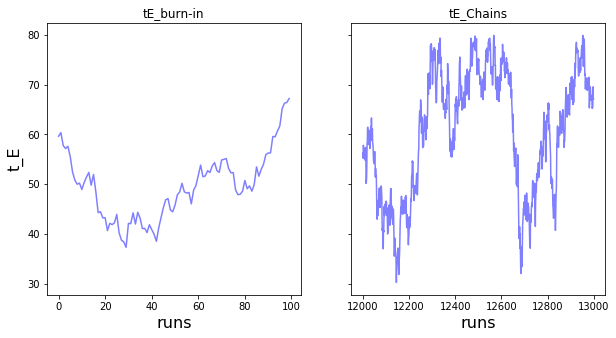

In [32]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5),sharey=True)
#ax = fig.add_subplot(1,2,1)
ax1.plot(np.arange(0,100,1),tE_model[0:100], color='blue',alpha=0.5)
ax1.set_xlabel("runs",fontsize=16)
ax1.set_ylabel("t_E",fontsize=16)
ax2.plot(np.arange(12000,13000,1),tE_model[12000:13000], color='blue',alpha=0.5)
ax2.set_xlabel("runs",fontsize=16)
ax1.set_title("tE_burn-in")
ax2.set_title("tE_Chains")

In [33]:
I0_best = np.median(I0_model[50:])
p_best = np.median(p_model[50:])
tmax_best = np.median(tmax_model[50:])
tE_best = np.median(tE_model[50:])
print("Best fit values I0:{:.3f}, p:{:.3f}, tmax:{:.3f}, tE:{:.3f}".format(I0_best,p_best,tmax_best,tE_best))

Best fit values I0:13.683, p:-0.648, tmax:505.719, tE:57.359


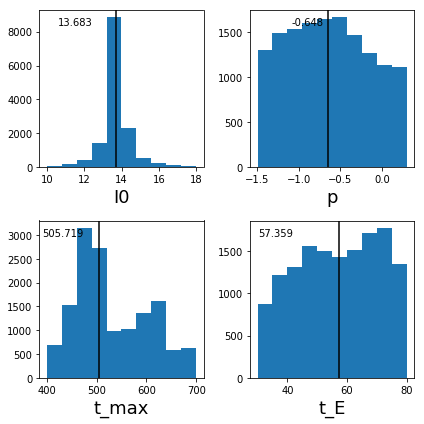

In [19]:
data = np.array([I0_model, p_model, tmax_model, tE_model])
xaxes = ["I0", "p", "t_max", "t_E"]
median_vals = np.array([I0_best, p_best, tmax_best, tE_best])
f,a = plt.subplots(2,2,figsize=(6,6))
a = a.ravel()
for idx,ax in enumerate(a):
    ax.hist(data[idx])
    ymin,ymax = ax.set_ylim()
    xmin,xmax = ax.set_xlim()
    ax.vlines(median_vals[idx],ymin,ymax)
    if idx == 1:
        ax.text(xmin+0.5,0.9*ymax,'{:.3f}'.format(median_vals[idx]))
    elif idx == 2:
        ax.text(xmin+5,0.9*ymax,'{:.3f}'.format(median_vals[idx]))
    else:
        ax.text(xmin+0.1*xmin,0.9*ymax,'{:.3f}'.format(median_vals[idx]))
    #ax.set_title(titles[idx])
    ax.set_xlabel(xaxes[idx],fontsize=18)
plt.tight_layout()

In [20]:
import corner

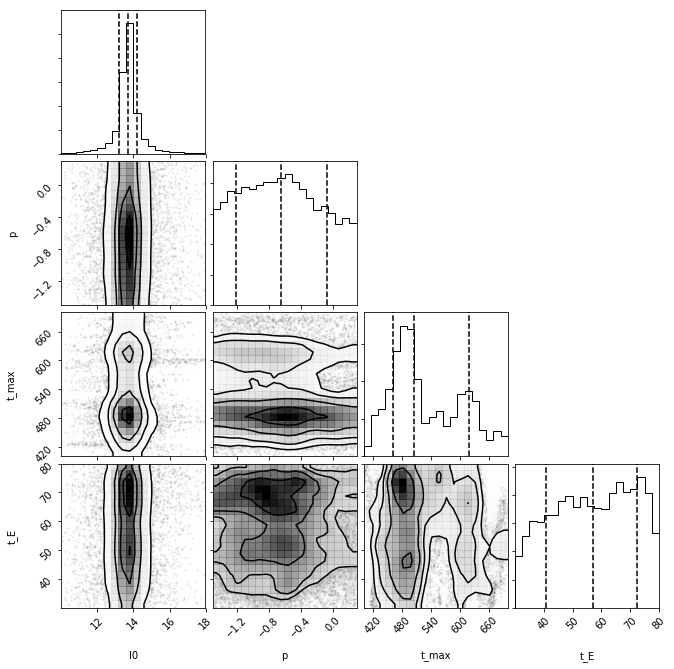

In [21]:
ndim = 4
nsamples = len(I0_model)
figure = corner.corner(data.T,
                       labels=["I0", "p", "t_max","t_E"],
                      quantiles=[0.16, 0.5, 0.84],
                      smooth=True)

In [22]:
model_best = model_func(JD,I0_best, p_best, tmax_best, tE_best)

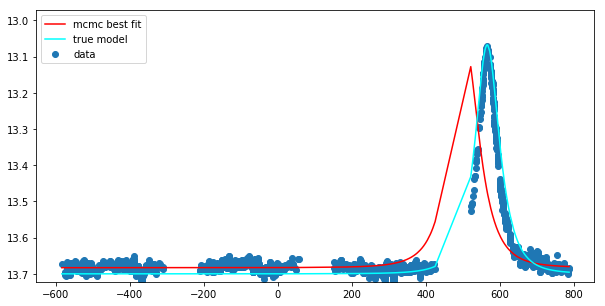

In [26]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1,1)
ax.scatter(JD,mag,label='data')
#ax.errorbar(JD,mag,yerr=mag_err)
ax.set_ylim(np.max(mag),np.min(mag)-0.1)
ax.plot(JD,model_best,color='r',label='mcmc best fit')
ax.plot(JD,model_func(JD,13.7 , -0.641, 566.35 , 50),color='cyan',label='true model')
ax.legend()